<a href='https://www.moh.gov.sa/en/Pages/Default.aspx'> <img style="float: left;height:70px" src="http://scienceacademy.ca/wp-content/uploads/2018/12/Logo_SA.png"></a>

Instructor and author: [_Dr. Junaid Qazi_](https://www.linkedin.com/in/jqazi/)

Hello guys, 

Having twitter account is a common practice in this era of social media, and many individuals express their feeling via their twitter accounts. This might be a good idea to see how Neural Networks can help us to extract or classify tweets for certain sentiment. 

`==>` *Tweets data is available at [kaggle](https://www.kaggle.com/c/tweet-sentiment-extraction/overview) and there is a prize money for the winners!*

At this stage, we all know that that [TensorFlow](https://www.tensorflow.org/) is a wonderful end-to-end open source platform for machine learning. Let's use this amazing platform to train a simple Convolutional Neural Network -- CNN and see if we can classify tweets into "`positive`","`negative`" and "`neutral`" sentiment! 

>Please note, I expect all of you to print message to update the status and progress of the process in this exercise. You can see several messages in the output to lead the user.....!

In [177]:
# Starting with the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

# sklearn imports
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# some tensorflow imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,regularizers,losses
from tensorflow.keras.layers import Embedding,Conv1D,GlobalMaxPooling1D,Dropout,Dense

#Setting display format to retina in matplotlib to see better quality images.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# just to ignore warnings
import warnings; warnings.filterwarnings('ignore')

In the cell below, I am importing some custom functions that I have placed in a directory name `custom_funcs` inside the current working directory. *Recall your python lecture on functions, where we learned to do this!*

In [34]:
# importing custom function from working directory
from custom_funcs.remove_emoji import remove_emoji 
from custom_funcs.remove_urls import remove_url
from custom_funcs.clean_tweet_text import clean_text

In [35]:
# Just making sure we are working with TF-2
import tensorflow as tf
print("the current tensorflow version in use is: ",tf.__version__)

the current tensorflow version in use is:  2.5.0


**reading the data from git.** *(you can download the file for off-line usage.)* 

In [144]:
train_url="""https://raw.githubusercontent.com/junaidqazi/\
DataSets_Practice_ScienceAcademy/master/Tweets_Sentiment_Analysis/train.csv"""
df= pd.read_csv(train_url)

**the data overview using `.info()`.** 

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


**looks like there is some missing data (only one tweet), let's drop it!**

*by the way, what would be your strategy if a small fraction is missing?*

In [146]:
#code here please
df.isnull().sum().sort_values(ascending=False)

text             1
selected_text    1
textID           0
sentiment        0
dtype: int64

In [147]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


**What is the minimum and maximum length (how many words) of a single tweet?** 

In [148]:
#code here please
df['tweetLength'] = df['text'].str.split().str.len()
min = df['tweetLength'].min()
max = df['tweetLength'].max()
print(f'Min Tweet length: {min}')
print(f'Max Tweet length: {max}')

Min Tweet length: 1
Max Tweet length: 33


Min tweet lenght:  1
Max tweet lenght:  33


**Select only the tweets that are more than 2 words long.** *(recall masking from dataframes lecture)*

In [48]:
df.head()

,textID,text,selected_text,sentiment,tweetLength
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2
2,088c60f138,my boss is bullying me...,bullying me,negative,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,3


In [150]:
df['Greater_two'] = df['tweetLength'] > 2
df['Greater_two'] = df['Greater_two'].replace(False, np.NAN)
df.dropna(inplace=True)
g2 = df['Greater_two'].value_counts()
print('Training dataset:')
print(f'Number of tweets having more than 2 words: {g2}')
g3 = df['sentiment'].value_counts()
print(f'Class count:\n{g3}')

Training dataset:
Number of tweets having more than 2 words: True    26752
Name: Greater_two, dtype: int64
Class count:
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64


Training dataset:
Number of tweets having more than 2 words:  26752
Class count:
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64


**Clean the data please.**
* remove emoji
* remove urls
* clean the text 

In [151]:
#code here please
df['text'] = df['text'].apply(remove_emoji)
print(f'training data -- removing emoji....')
df['text'] = df['text'].apply(remove_url)
print(f'training data -- removing urls....')
df['text'] = df['text'].apply(clean_text)
print(f'training data -- cleaning text....')
df.head(1)

training data -- removing emoji....
training data -- removing urls....
training data -- cleaning text....


,textID,text,selected_text,sentiment,tweetLength,Greater_two
0,cb774db0d1,have responded were going,"I`d have responded, if I were going",neutral,7,True


training data -- removing emoji....
training data -- removing urls....
training data -- cleaning text....
training data -- Done!


*A quick question to see if you are still with me! Why the number in n_words is different than the word count in text column?*

#### Working with the train part of the data.

Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

**Initialize the [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) and fit to the text column.**

*(from TF documentation) This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...*

***please set `oov_token='unknown'` while creating `Tokenizer` instances, can you explain this parameter?*** *(hint: out-of-vocabulary)*

In [152]:
#code here please
print(f'Max words to keep: 20000')
tokenizer = Tokenizer(num_words=20000, oov_token='unknown')
print(f'token initilized....')
tokenizer.fit_on_texts(df['text'])
print(f'fitting on tweets...')
print(f'Done!')

Max words to keep: 20000
token initilized....
fitting on tweets...
Done!


max words to keep: 20000
tokenizer initilized....
fitting on tweets ....
Done!


**please check the index of 'unknown'**

In [153]:
#code here please
index = tokenizer.word_index['unknown']
print(f'Index of word \'unknown\' is {index}')

Index of word 'unknown' is 5284


index of word 'unknown' is: 5284


**(extra learning question) Get the sequence for `'I am Junaid; xyz how are you -- unknown'`**

*What do you see, explain the reason to have same number for several words?*

In [154]:
#code here please
tokenizer.texts_to_sequences(['I am Juaid; xyz hhow are you -- unknown'])

[[5284, 5284, 5284, 5284, 5284, 21, 4, 5284]]

[[5284, 5284, 5284, 5284, 58, 21, 4, 5284]]


**Split the data into train and test part.**

Class is imbalanced, how will you handle this without re-sampling? 

In [60]:
df.head()

,textID,text,selected_text,sentiment,tweetLength
0,cb774db0d1,have responded were going,"I`d have responded, if I were going",neutral,7
1,549e992a42,sooo sad will miss you here san diego,Sooo SAD,negative,10
2,088c60f138,boss bullying,bullying me,negative,5
3,9642c003ef,what interview leave alone,leave me alone,negative,5
4,358bd9e861,sons why couldnt they put them the releases al...,"Sons of ****,",negative,14


In [167]:
#code here please
# ¯\_(ツ)_/¯ Not sure to pass through tokenizer
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42, stratify = y)
print(f'X_train length:')
display(len(X_train))
print(f'y_train:')
display(y_train.value_counts().to_dict())
print(f'X_test length:')
display(len(X_test))
print(f'y_train:')
display(y_test.value_counts().to_dict())

X_train length:


17923

y_train:


{'neutral': 7171, 'positive': 5611, 'negative': 5141}

X_test length:


8829

y_train:


{'neutral': 3533, 'positive': 2764, 'negative': 2532}

saperating tweet and the sentiment....
splitting into train and test using train_test_split()....
(X_train) -- train data len: 24076
(y_train) -- class distribution:  Counter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
(X_test)  -- valid data len: 2676
(y_test)  -- class distribution:  Counter({'neutral': 1071, 'positive': 838, 'negative': 767})


**Get sequences and pad them with max_tweet_length (I am using `maxlen=36`).**

`==>` Learning trick: 

* try different values of `maxlen` and observe the difference in the model performance and compute/training time.
* try using list of tokens and arrays of tokens to see the difference in training.

In [168]:
#Code here please
# Should I replace 36 with the actual maxlen of Xtrain?
ps_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = 36, padding = 'post')
ps_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = 36, padding = 'post')

display(type(ps_train))
display(type(ps_test))

display(ps_train[0])
len(ps_train[0])

numpy.ndarray

numpy.ndarray

array([ 158,    2, 2470, 1543, 6109,   21, 1101,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

36

getting sequences for X_train and X_test, we are working with numpay arrays of tokens here....!

type of training data:  <class 'numpy.ndarray'>
type of test data    :  <class 'numpy.ndarray'>

the max tweet length is: 33
setting maxlen for padding max_tweet_len + 3 .... 

all sequences are padded and this is how the first tweet look like now...

sequence of our first tweet from training data:
 [ 151   83  109  248  172  135  207 5284    2  775    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
lenght of the sequence is:  36


**Encode the labels/targets in appropriate format for TF.**

In [178]:
#code here please
le  = LabelEncoder()

display(y_train[0:5])
y_train = le.fit_transform(y_train)
display(y_train[0:5])

display(y_test[0:5])
y_test = le.fit_transform(y_test)
display(y_test[0:5])

# Convert to arrays of binary encoding
binzr = LabelBinarizer()
display(binzr.fit_transform(y_train))

array([0, 0, 1, 0, 2], dtype=int64)

array([0, 0, 1, 0, 2], dtype=int64)

array([1, 1, 1, 1, 2], dtype=int64)

array([1, 1, 1, 1, 2], dtype=int64)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

y_train part

first two labels look like ....
22509    positive
27375     neutral
Name: sentiment, dtype: object

initilizing label encoder....
converting targets to numetic coding....
labels are encoded:  [2 1 1 ... 1 2 1]
converting into arrays of binary encoding -- ready for TF ....

first two final labels look like....
---------------
y_train part 
[[0. 0. 1.]
 [0. 1. 0.]]
---------------
y_test part 

[[0. 0. 1.]
 [0. 0. 1.]]
---------------

the label order is:  ['negative', 'neutral', 'positive']


**In the above train and test encoded labels, which sentiment they are representing?**

In [27]:
#Ans: they are representing negative, neutral, and positive

**what is the purpose of [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) explore the documentation.**

In [28]:
#code here please


train_ds is  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
test_ds is  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


**Please print first two observations in the train and test part.** 

*please use `for loop` with `break` statement ...*

In [30]:
#code here please

-----------------
train data part
-----------------
tf.Tensor(
[ 151   83  109  248  172  135  207 5284    2  775    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int32) 
 tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
-----------------
test data part
-----------------
tf.Tensor(
[  34   51   11 1698 3968 1150    3 1829   22   23 2201 7643    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int32) 
 tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
-------------------


**Create a simple CNN -- Convolutional Neural Network using [sequential API](https://www.tensorflow.org/guide/keras/sequential_model).**

*(from TF documentation) A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.*

In [32]:
max_features =20000
embedding_dim =100
sequence_length = 36 # equal to max lenght with padding

model = Sequential()
#Embedding layer
model.add(Embedding(max_features +1, # recall the reson of +1 from lecture
                    embedding_dim,
                    input_length=sequence_length,
                    embeddings_regularizer=regularizers.l2(0.0005)))                                    
# first Conv1D layer
model.add(Conv1D(128,3,activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005),
                 bias_regularizer=regularizers.l2(0.0005)))                               
#GlobalMaxPooling1D
model.add(GlobalMaxPooling1D())
# dropput layer 
model.add(Dropout(0.5))
# Dense layer
model.add(Dense(3, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),))
#Compileing model
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam', metrics=["CategoricalAccuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 128)           38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,039,015
Trainable params: 2,039,015
Non-trainable params: 0
_________________________________________________________________


**can you justify the  total number of parameters in your model summary?**

In [33]:
#Ans:

**Train your network** Use 100 epochs, 

In [34]:
#code here please

Epoch 1/100
121/121 [==============================] - 10s 75ms/step - loss: 1.1636 - categorical_accuracy: 0.5343 - val_loss: 0.8609 - val_categorical_accuracy: 0.6674
Epoch 2/100
121/121 [==============================] - 9s 72ms/step - loss: 0.8105 - categorical_accuracy: 0.7008 - val_loss: 0.8183 - val_categorical_accuracy: 0.6988
Epoch 3/100
121/121 [==============================] - 9s 74ms/step - loss: 0.7671 - categorical_accuracy: 0.7262 - val_loss: 0.8204 - val_categorical_accuracy: 0.7048
Epoch 4/100
121/121 [==============================] - 9s 73ms/step - loss: 0.7430 - categorical_accuracy: 0.7431 - val_loss: 0.8354 - val_categorical_accuracy: 0.7055
Epoch 5/100
121/121 [==============================] - 9s 72ms/step - loss: 0.7250 - categorical_accuracy: 0.7568 - val_loss: 0.8501 - val_categorical_accuracy: 0.7089
Epoch 6/100
121/121 [==============================] - 9s 72ms/step - loss: 0.7113 - categorical_accuracy: 0.7728 - val_loss: 0.8730 - val_categorical_accuracy

121/121 [==============================] - 9s 70ms/step - loss: 0.4573 - categorical_accuracy: 0.9547 - val_loss: 1.2025 - val_categorical_accuracy: 0.6562
Epoch 98/100
121/121 [==============================] - 8s 70ms/step - loss: 0.4575 - categorical_accuracy: 0.9537 - val_loss: 1.1989 - val_categorical_accuracy: 0.6622
Epoch 99/100
121/121 [==============================] - 9s 70ms/step - loss: 0.4580 - categorical_accuracy: 0.9534 - val_loss: 1.1986 - val_categorical_accuracy: 0.6584
Epoch 100/100
121/121 [==============================] - 8s 69ms/step - loss: 0.4554 - categorical_accuracy: 0.9543 - val_loss: 1.1912 - val_categorical_accuracy: 0.6584

training time: 1279.292358160019
epochs: 100


In [36]:
#history is history object and model is trained cnn model

In [37]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

**Re-create the plots below from history and explain the curves.**

In [38]:
#code here please

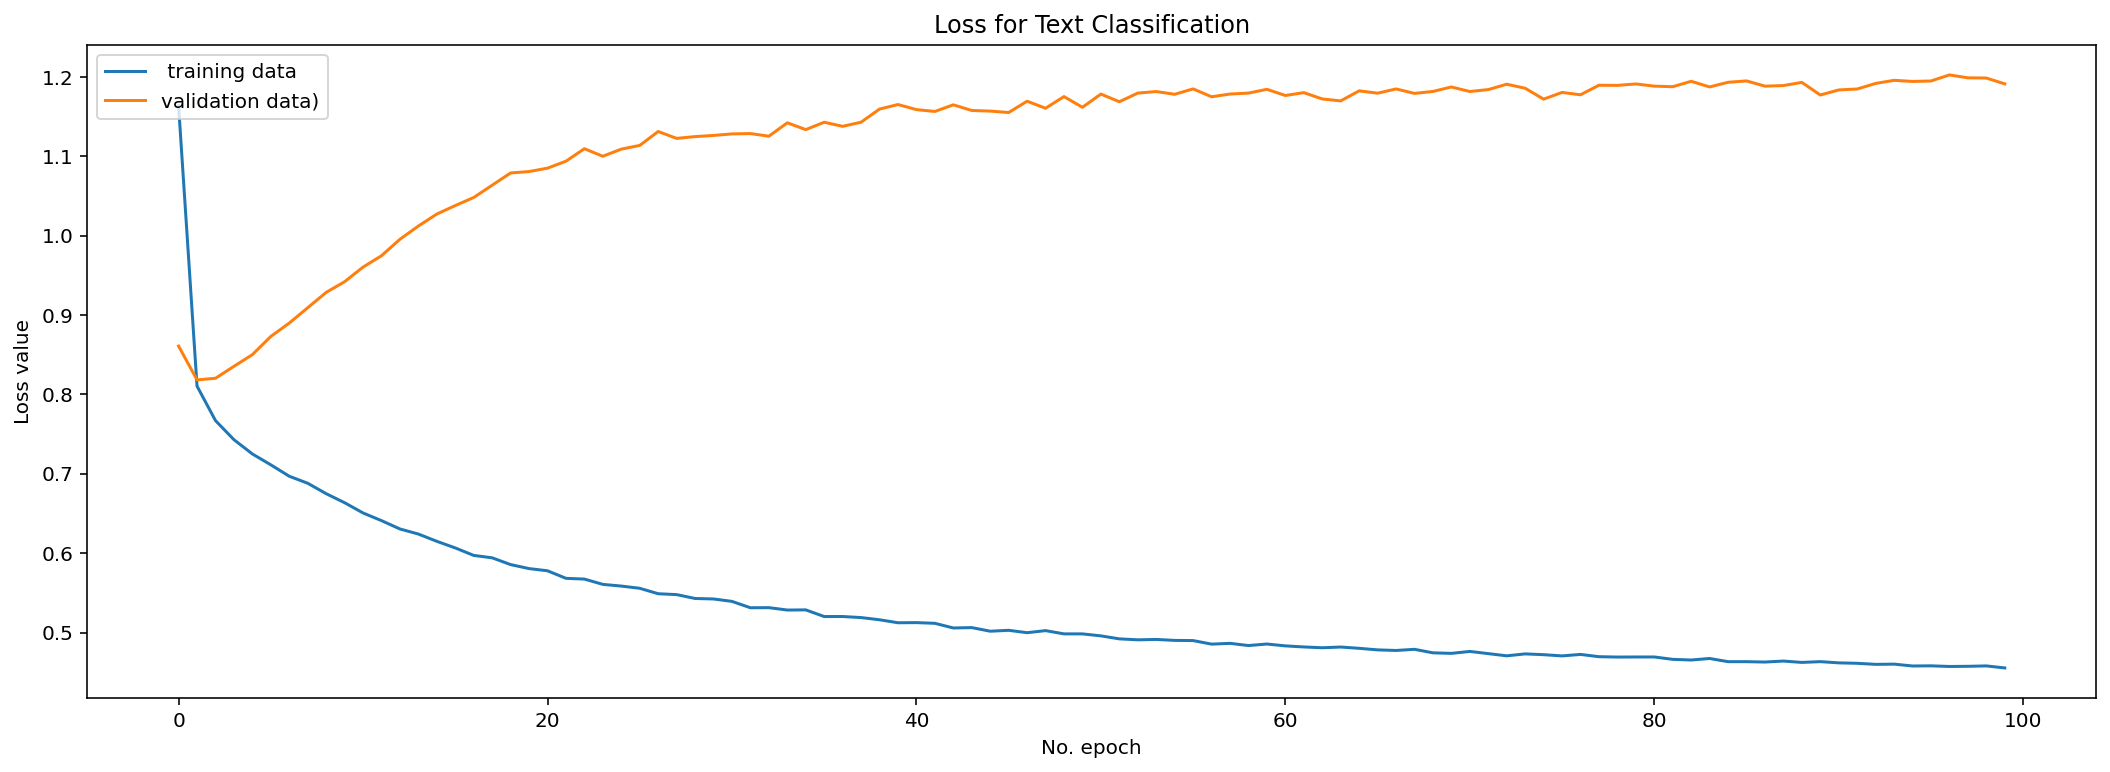

In [39]:
plt.figure(figsize=(18,6))
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left");

In [40]:
#code here please

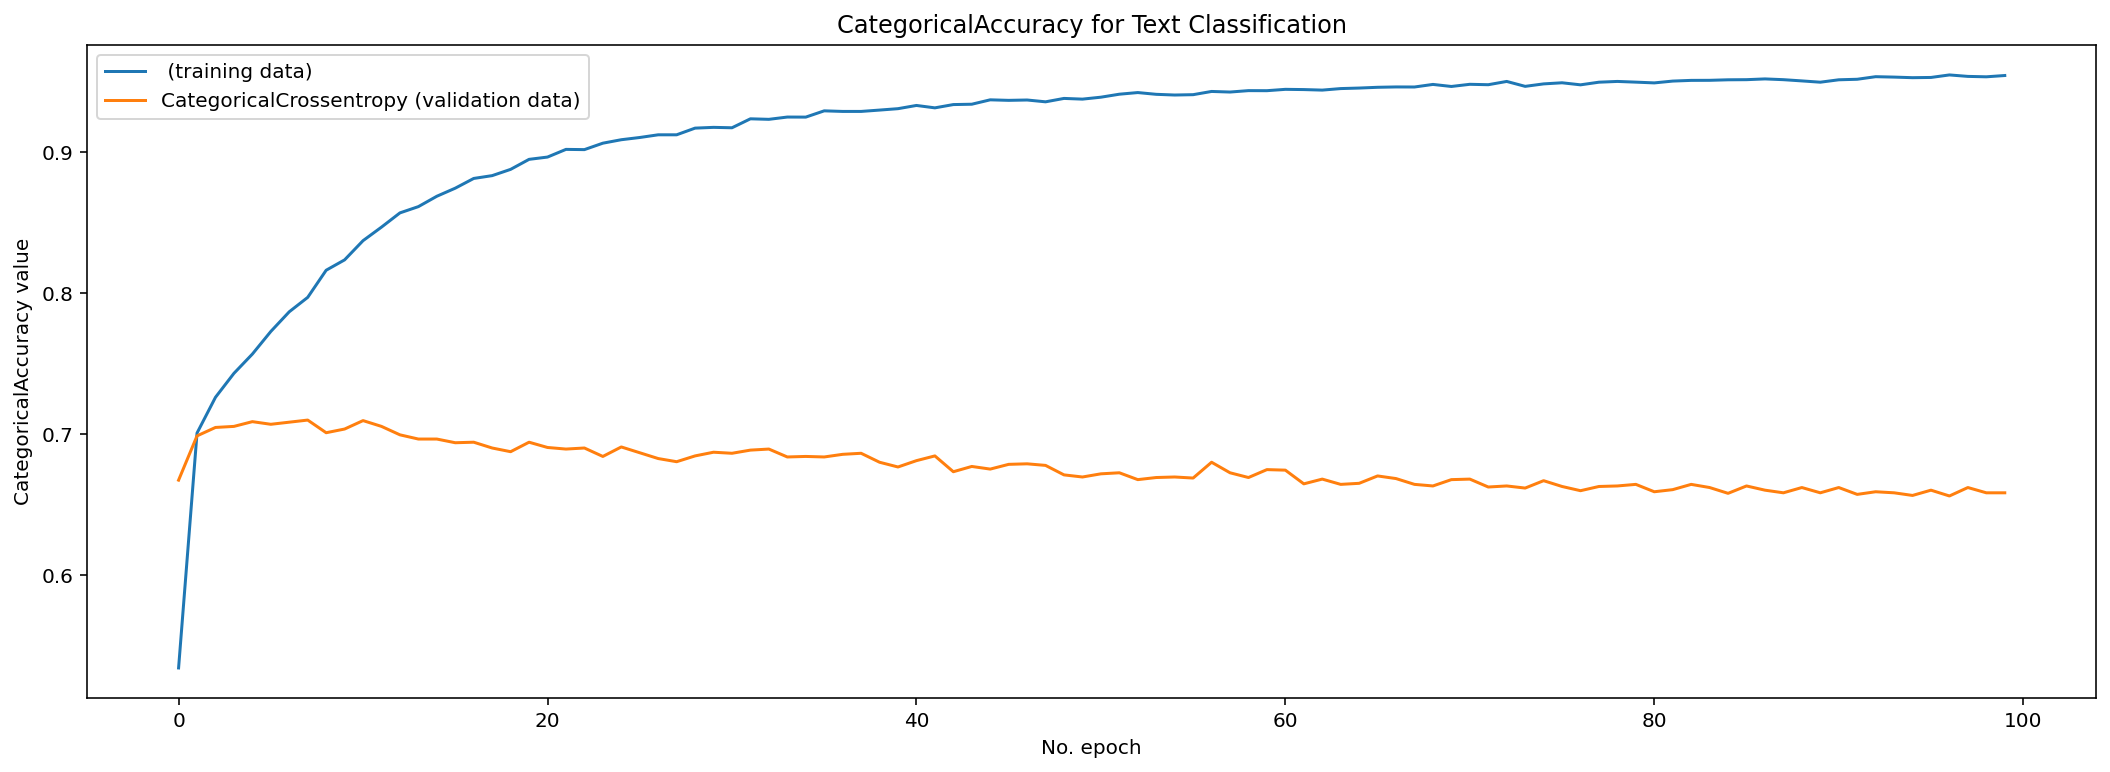

**Save your trained model and the tokenizer** 

*use model.save module and convert tokenizer into json before saving -- import jason!*

In [42]:
#code here please

saving model....
INFO:tensorflow:Assets written to: ./saved_models_tweet_sentiment/tf_cnn_model/assets
model saved at './saved_models_tweet_sentiment/tf_cnn_model'
converting tokenizer to json....
saviing tokenizer.....
tokenizer saved at './saved_models_tweet_sentiment/tokenizer.json'

saved model and tokenizer is ready for future use....


`==>`learning trick: open the saved tokenizer.json and look for some word, what do you see for unknown?

------------
------------
------------
## Here the test data comes in -- your 2nd file

In [44]:
test_url="""https://raw.githubusercontent.com/junaidqazi/\
DataSets_Practice_ScienceAcademy/master/Tweets_Sentiment_Analysis/test.csv"""
test_data= pd.read_csv(test_url)

**Repeat all the above steps that you have performed on the above dataset.**

In [45]:
#code here please 

working with test data...

number of tweets in test data: 3534
dropping the possible rows with null value....
no missing data found, nothing to drop...
min tweet lenght:  1
max tweet lenght:  32
removing all the tweets with less than two word count....
number of tweets having more than 2 words:  3434
class count:
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
test data -- removing emoji....
test data -- removing urls....
test data -- cleaning text....
test data -- Done!


**separate data to features and labels and then transform labels into appropriate format.** 

In [47]:
#code here please

categorical numeric labels: [1 2 0 2 2]
binary coded:
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


**load tokenizer and get the sequences and pad them with to maxlen=36, same as above**

In [49]:
#code here please

loading saved tokenizer....
saved tokenizer is loaded....
getting sequences for the test data and adding padding accordingly....
All done, data is ready for predictions.....


**Load the saved model and get predictions for the test data**

In [51]:
#code here please

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 128)           38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,039,015
Trainable params: 2,039,015
Non-trainable params: 0
_________________________________________________________________


**Generate predictions (probabilities -- the output of the last layer) on test  data using `predict`**

In [53]:
#code here please

Generate predictions for all samples
first 5 prediction are:
[[0.1491861  0.718873   0.6773205 ]
 [0.07649285 0.5513598  0.90449154]
 [0.9775305  0.8275697  0.00450569]
 [0.4055374  0.653259   0.42463613]
 [0.00399935 0.4435264  0.99665725]]
first 5 predicted results are: [1 2 0 1 2]


**Can you think about creating classification report and confusion matrix for the predictions?**

In [55]:
#code here please

              precision    recall  f1-score   support

    positive       0.77      0.71      0.74      1075
    negative       0.67      0.67      0.67       983
     neutral       0.63      0.67      0.65      1376

    accuracy                           0.68      3434
   macro avg       0.69      0.68      0.68      3434
weighted avg       0.68      0.68      0.68      3434



In [58]:
#code here please

array([[763,  58, 254],
       [ 36, 659, 288],
       [187, 273, 916]])

## To Do:

* Think about improving the model, what can be done?
* Build LSTM network and compare the performance.

*Note: see the extension of your saved model in the folder, where you have saved the model. The`.pb` extension stands for protobuf ([protocol buffers](https://developers.google.com/protocol-buffers/)). Protocol buffers are a language-neutral, platform-neutral extensible mechanism for serializing structured data. In TensorFlow, the `.pb` is all you need to be able to run a given trained model.* 

## License{-}

Author: [___Dr. Junaid Qazi___](https://www.linkedin.com/in/jqazi/)

Twitter: [***@JunaidSQazi***](https://twitter.com/JunaidSQazi)

Copyright 2021

Licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0) (the "License").<br>you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. Please see the License for the specific language governing permissions and limitations under the License.*


*This is not an official product but sample code provided for an educational purpose.*

***Acknowledgement is requested***

\pagebreak